In [1]:
%%capture
!pip install open3d pytorch-lightning

Download and prepare a (very) small dataset

In [2]:
!wget 'https://versaweb.dl.sourceforge.net/project/pointclouds/PCD%20datasets/hand_gestures.zip'

--2023-10-09 19:53:42--  https://versaweb.dl.sourceforge.net/project/pointclouds/PCD%20datasets/hand_gestures.zip
Resolving versaweb.dl.sourceforge.net (versaweb.dl.sourceforge.net)... 162.251.232.173
Connecting to versaweb.dl.sourceforge.net (versaweb.dl.sourceforge.net)|162.251.232.173|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://downloads.sourceforge.net/project/pointclouds/PCD%20datasets/hand_gestures.zip?download&failedmirror=versaweb.dl.sourceforge.net [following]
--2023-10-09 19:53:43--  https://downloads.sourceforge.net/project/pointclouds/PCD%20datasets/hand_gestures.zip?download&failedmirror=versaweb.dl.sourceforge.net
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://master.dl.sourceforge.net/project/pointclouds/PCD%20datas

In [ ]:
!unzip -q hand_gestures.zip
!cp -r hand_gestures/ test/
!cp -r test/ train/
!rm test/hand_{0..7}/image_{0002..0009}.pcd
!rm train/hand_{0..7}/image_{0000..0001}.pcd

Inspect an example

In [4]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go

def show_points(points, colors=None):

    if colors is None:
        colors = np.full((len(points),3),[0, 1, 0]) # fixed color

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=points[:,0], y=points[:,1], z=points[:,2],
                mode='markers',
                marker=dict(size=1, color=colors)
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [5]:
cloud = o3d.io.read_point_cloud("test/hand_1/image_0001.pcd")

show_points(np.asarray(cloud.points), colors=np.asarray(cloud.colors))

Create dataset module

In [6]:
import torch
import os
from glob import glob
import random

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.samples = sorted([y for y in glob(os.path.join(root_dir, '*', '*.pcd'))])
        if not len(self.samples) > 0:
            print("did not find any files")
        self.transform = transform

    def load_sample(self, path):
        cloud = o3d.io.read_point_cloud(path)
        points = np.asarray(cloud.points)
        cls = int(path.split('/')[1].split('_')[1])
        cls = torch.nn.functional.one_hot(torch.as_tensor(cls), 8)
        return points, cls

    def sample_N_random(self,x,N=1024):
        candiate_ids = [i for i in range(x.shape[0])]
        sel = []
        for _ in range(N):
            # select idx
            idx = random.randint(0,len(candiate_ids)-1)
            sel.append(candiate_ids[idx])
            # remove that idx from point_idx_options
            del candiate_ids[idx]
        return np.array(x[sel])

    def __getitem__(self, idx):
        x, y = self.load_sample(self.samples[idx])
        x = self.sample_N_random(x)
        #sample = {'input':x}
        #if self.transform:
        #    sample = self.transform(**sample)
        #    x = sample['input']
        return torch.as_tensor(x).float(), y.float()

    def __len__(self):
        return len(self.samples)


Verify the output of the dataset module

In [7]:
data_train = Dataset('train/',transform=None)
x ,y = data_train[15]
print(y)
show_points(x.numpy())

tensor([0., 1., 0., 0., 0., 0., 0., 0.])


Define PointNet and ClassHead

In [8]:
import torch
import torch.nn as nn

class PointNet(nn.Module):
    def __init__(self, input_dims=3):
        super(PointNet, self).__init__()
        self.conv1 = torch.nn.Conv1d(input_dims, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = x.transpose(2, 1)
        x = F.leaky_relu(self.bn1(self.conv1(x)),0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        feat = x.view(-1, 1024)
        return feat

class ClassHead(nn.Module):
    def __init__(self, input_dims=1024, output_dims=3, dropout_prob=0.5):
        super(ClassHead, self).__init__()
        self.fc1 = nn.Linear(input_dims, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_dims)
        self.do = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.do(self.fc1(x))),0.2)
        x = F.leaky_relu(self.bn2(self.do(self.fc2(x))),0.2)
        x = self.fc3(x)
        return x

Build training module

In [20]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import pytorch_lightning as pl

class Classifier(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.encoder = PointNet()
        self.decoder = ClassHead(output_dims=cfg['n_classes'])

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        return Adam(self.parameters(),
                    lr=self.cfg['lr'])

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = F.mse_loss(output, y)
        self.log('loss', loss, on_step=True, prog_bar=True, logger=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = F.mse_loss(output, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss}

Config

In [10]:
cfg = {
        'experiment': 'hands',
        'train_folder': 'train/',
        'test_folder': 'test/',
        'n_points': 1024,
        'n_classes': 8,
        'max_epoch': 20,
        'accelerator': 'gpu',
        'devices': 1,
        'lr': 0.0005,
        'batch_size': 16,
        'device': 'cuda',
      }

Train a model

In [21]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer, loggers

pl.seed_everything(42)
#logger = pl.loggers.TensorBoardLogger('logs/',cfg['experiment']) # doesn't seem to work in colab or kaggle at the moment
logger = pl.loggers.CSVLogger('logs/', name=cfg['experiment'])

from torch.utils.data import DataLoader
train_dataloader = DataLoader(Dataset('train/',transform=None), batch_size=cfg['batch_size'], shuffle=True)
val_dataloader = DataLoader(Dataset('test/',transform=None), batch_size=cfg['batch_size'], shuffle=False)

model = Classifier(cfg)
model.train()
trainer = Trainer(accelerator=cfg['accelerator'], devices=cfg['devices'], max_epochs=cfg['max_epoch'], logger=logger, log_every_n_steps=4, deterministic=True)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

model_dir = os.path.join("trained_models/",cfg['experiment'])
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
torch.save(model.encoder, os.path.join(model_dir,"encoder.pt"))
torch.save(model.decoder, os.path.join(model_dir,"decoder.pt"))
torch.save(model, os.path.join(model_dir,"model.pt"))

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | encoder | PointNet  | 143 K 
1 | decoder | ClassHead | 280 K 
--------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.692     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Load the TensorBoard notebook extension (doesn't seem to work anymore)
#%load_ext tensorboard
#%tensorboard --logdir='logs/'

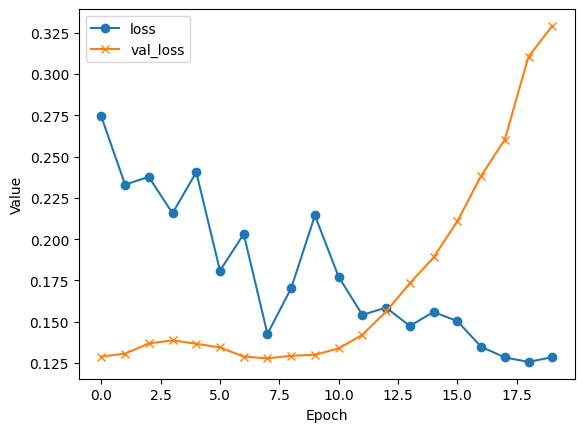

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
metrics_df = pd.read_csv('logs/hands/version_0/metrics.csv')
df_agg = metrics_df.groupby('epoch').agg({
    'loss': 'mean',
    'val_loss': 'mean'
}).reset_index()
plt.plot(df_agg['epoch'], df_agg['loss'], label='loss', marker='o')
plt.plot(df_agg['epoch'], df_agg['val_loss'], label='val_loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


Try the model. Given the small dataset and the lack of serious data augmentation performance is poor. (Check if the model has learned the training set?)

In [29]:
with torch.no_grad():
    model.eval()
    data_test = Dataset('test/',transform=None)
    for sample in data_test:
        x, y = sample
        pred = model(torch.unsqueeze(x, 0))[0]
        print("GT: {}, Pred {}".format(torch.argmax(y, dim=0),torch.argmax(pred, dim=0)))
        #show_points(x.numpy())

GT: 0, Pred 6
GT: 0, Pred 1
GT: 1, Pred 6
GT: 1, Pred 1
GT: 2, Pred 6
GT: 2, Pred 1
GT: 3, Pred 6
GT: 3, Pred 1
GT: 4, Pred 6
GT: 4, Pred 1
GT: 5, Pred 6
GT: 5, Pred 1
GT: 6, Pred 6
GT: 6, Pred 1
GT: 7, Pred 6
GT: 7, Pred 1
